In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from functools import reduce
import numpy as np
import libpysal as lps
import seaborn as sns
import libpysal as lps
import pysal as ps
from libpysal.weights import Queen, Rook, KNN
from shapely import wkt
from scipy.spatial import cKDTree
import sklearn.model_selection as model_select
from math import sqrt
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor
from libpysal import weights
try:
    from scipy.optimize import minimize_scalar
    minimize_scalar_available = True
except ImportError:
    minimize_scalar_available = False
import warnings
warnings.simplefilter('ignore')

In [2]:
pd.set_option('display.max_rows', 1000)

In [3]:
#sorghum residue
sorghum18=pd.read_csv("dataset/production/Sorghum_2018.csv",usecols=["Area Code (FAO)","Sorghum_Residue"])

In [4]:
sorghum18.isnull().sum()

Area Code (FAO)    0
Sorghum_Residue    0
dtype: int64

In [5]:
#read country code
country_code=pd.read_csv("dataset/country_data.csv",usecols=["Country Code","Country","ISO2 Code","ISO3 Code"])
country_code.head()

,Country Code,Country,ISO2 Code,ISO3 Code
0,2,Afghanistan,AF,AFG
1,5100,Africa,NaN,X06
2,3,Albania,AL,ALB
3,4,Algeria,DZ,DZA
4,5,American Samoa,AS,ASM


In [6]:
#country area
area=pd.read_csv("dataset/cropland/country_area.csv",usecols=["country_area","ISO3 Code"])
area.head()

,ISO3 Code,country_area
0,ABW,180.0
1,AFG,652860.0
2,AGO,1246700.0
3,ALB,28750.0
4,AND,470.0


In [7]:
#read shapefile
poly=gpd.read_file("dataset/wb_countries_admin0_10m/wb_countries_admin0_10m.shp")
poly.columns

Index(['OBJECTID', 'featurecla', 'LEVEL', 'TYPE', 'FORMAL_EN', 'FORMAL_FR',
       'POP_EST', 'POP_RANK', 'GDP_MD_EST', 'POP_YEAR', 'LASTCENSUS',
       'GDP_YEAR', 'ECONOMY', 'INCOME_GRP', 'FIPS_10_', 'ISO_A2', 'ISO_A3',
       'ISO_A3_EH', 'ISO_N3', 'UN_A3', 'WB_A2', 'WB_A3', 'CONTINENT',
       'REGION_UN', 'SUBREGION', 'REGION_WB', 'NAME_AR', 'NAME_BN', 'NAME_DE',
       'NAME_EN', 'NAME_ES', 'NAME_FR', 'NAME_EL', 'NAME_HI', 'NAME_HU',
       'NAME_ID', 'NAME_IT', 'NAME_JA', 'NAME_KO', 'NAME_NL', 'NAME_PL',
       'NAME_PT', 'NAME_RU', 'NAME_SV', 'NAME_TR', 'NAME_VI', 'NAME_ZH',
       'WB_NAME', 'WB_RULES', 'WB_REGION', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')

In [8]:
poly.loc[50,"ISO_A3_EH"]="NOR"

In [9]:
#merge country code and shapefile
country_poly=pd.merge(country_code,poly,left_on="ISO3 Code",right_on="ISO_A3_EH",how="inner")
country_poly.head()

,Country Code,Country,ISO2 Code,ISO3 Code,OBJECTID,featurecla,LEVEL,TYPE,FORMAL_EN,FORMAL_FR,...,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,WB_NAME,WB_RULES,WB_REGION,Shape_Leng,Shape_Area,geometry
0,2,Afghanistan,AF,AFG,126,Admin-0 country,2,Sovereign country,Islamic State of Afghanistan,None,...,Afghanistan,Afganistan,Afghanistan,阿富汗,Afghanistan,None,SOA,52.765827,62.591664,"POLYGON ((74.54235 37.02167, 74.54742 37.01567..."
1,3,Albania,AL,ALB,61,Admin-0 country,2,Sovereign country,Republic of Albania,None,...,Albanien,Arnavutluk,Albania,阿尔巴尼亚,Albania,None,ECA,11.050457,3.039395,"POLYGON ((20.56715 41.87318, 20.54172 41.86158..."
2,4,Algeria,DZ,DZA,118,Admin-0 country,2,Sovereign country,People's Democratic Republic of Algeria,None,...,Algeriet,Cezayir,Algérie,阿尔及利亚,Algeria,None,MENA,71.641687,212.690941,"POLYGON ((6.58326 36.98981, 6.59946 36.97309, ..."
3,5,American Samoa,AS,ASM,228,Admin-0 country,2,Dependency,American Samoa,None,...,Amerikanska Samoa,Amerikan Samoası,Samoa thuộc Mỹ,美屬薩摩亞,American Samoa (US),Name in italic,Other,1.073705,0.015101,"MULTIPOLYGON (((-170.59101 -14.26483, -170.576..."
4,6,Andorra,AD,AND,125,Admin-0 country,2,Sovereign country,Principality of Andorra,None,...,Andorra,Andorra,Andorra,安道尔,Andorra,None,Other,1.057953,0.049561,"POLYGON ((1.70701 42.50278, 1.69750 42.49446, ..."


In [10]:
country_poly1=pd.merge(country_poly,area,on="ISO3 Code",how="outer")
country_poly1.head()

,Country Code,Country,ISO2 Code,ISO3 Code,OBJECTID,featurecla,LEVEL,TYPE,FORMAL_EN,FORMAL_FR,...,NAME_TR,NAME_VI,NAME_ZH,WB_NAME,WB_RULES,WB_REGION,Shape_Leng,Shape_Area,geometry,country_area
0,2,Afghanistan,AF,AFG,126,Admin-0 country,2,Sovereign country,Islamic State of Afghanistan,None,...,Afganistan,Afghanistan,阿富汗,Afghanistan,None,SOA,52.765827,62.591664,"POLYGON ((74.54235 37.02167, 74.54742 37.01567...",652860.0
1,3,Albania,AL,ALB,61,Admin-0 country,2,Sovereign country,Republic of Albania,None,...,Arnavutluk,Albania,阿尔巴尼亚,Albania,None,ECA,11.050457,3.039395,"POLYGON ((20.56715 41.87318, 20.54172 41.86158...",28750.0
2,4,Algeria,DZ,DZA,118,Admin-0 country,2,Sovereign country,People's Democratic Republic of Algeria,None,...,Cezayir,Algérie,阿尔及利亚,Algeria,None,MENA,71.641687,212.690941,"POLYGON ((6.58326 36.98981, 6.59946 36.97309, ...",2381741.0
3,5,American Samoa,AS,ASM,228,Admin-0 country,2,Dependency,American Samoa,None,...,Amerikan Samoası,Samoa thuộc Mỹ,美屬薩摩亞,American Samoa (US),Name in italic,Other,1.073705,0.015101,"MULTIPOLYGON (((-170.59101 -14.26483, -170.576...",200.0
4,6,Andorra,AD,AND,125,Admin-0 country,2,Sovereign country,Principality of Andorra,None,...,Andorra,Andorra,安道尔,Andorra,None,Other,1.057953,0.049561,"POLYGON ((1.70701 42.50278, 1.69750 42.49446, ...",470.0


In [11]:
#select columns
country_poly1=pd.DataFrame(country_poly1,columns=["Country Code","Country","geometry","CONTINENT","country_area"])
country_poly1.head()

,Country Code,Country,geometry,CONTINENT,country_area
0,2,Afghanistan,"POLYGON ((74.54235 37.02167, 74.54742 37.01567...",Asia,652860.0
1,3,Albania,"POLYGON ((20.56715 41.87318, 20.54172 41.86158...",Europe,28750.0
2,4,Algeria,"POLYGON ((6.58326 36.98981, 6.59946 36.97309, ...",Africa,2381741.0
3,5,American Samoa,"MULTIPOLYGON (((-170.59101 -14.26483, -170.576...",Oceania,200.0
4,6,Andorra,"POLYGON ((1.70701 42.50278, 1.69750 42.49446, ...",Europe,470.0


In [12]:
sorghum18_g=pd.merge(country_poly1,sorghum18,left_on="Country Code",right_on="Area Code (FAO)",how="outer")
sorghum18_g=gpd.GeoDataFrame(sorghum18_g)
sorghum18_g

,Country Code,Country,geometry,CONTINENT,country_area,Area Code (FAO),Sorghum_Residue
0,2.0,Afghanistan,"POLYGON ((74.54235 37.02167, 74.54742 37.01567...",Asia,6.528600e+05,NaN,NaN
1,3.0,Albania,"POLYGON ((20.56715 41.87318, 20.54172 41.86158...",Europe,2.875000e+04,NaN,NaN
2,4.0,Algeria,"POLYGON ((6.58326 36.98981, 6.59946 36.97309, ...",Africa,2.381741e+06,4.0,6338.50
3,5.0,American Samoa,"MULTIPOLYGON (((-170.59101 -14.26483, -170.576...",Oceania,2.000000e+02,NaN,NaN
4,6.0,Andorra,"POLYGON ((1.70701 42.50278, 1.69750 42.49446, ...",Europe,4.700000e+02,NaN,NaN
5,7.0,Angola,"MULTIPOLYGON (((13.07370 -4.63532, 13.06533 -4...",Africa,1.246700e+06,7.0,69629.00
6,258.0,Anguilla,"MULTIPOLYGON (((-63.00739 18.27302, -62.98400 ...",North America,1.020000e+02,NaN,NaN
7,8.0,Antigua and Barbuda,"MULTIPOLYGON (((-61.88362 17.04902, -61.87922 ...",North America,4.400000e+02,NaN,NaN
8,9.0,Argentina,"MULTIPOLYGON (((-67.28475 -23.83414, -67.25133...",South America,2.780400e+06,9.0,2736028.75
9,1.0,Armenia,"MULTIPOLYGON (((45.00240 41.29045, 45.03940 41...",Asia,2.974000e+04,NaN,NaN


In [13]:
sorghum18_g=sorghum18_g.drop([227,228])

Text(0.5, 1, 'Sorghum Residues (2018)')

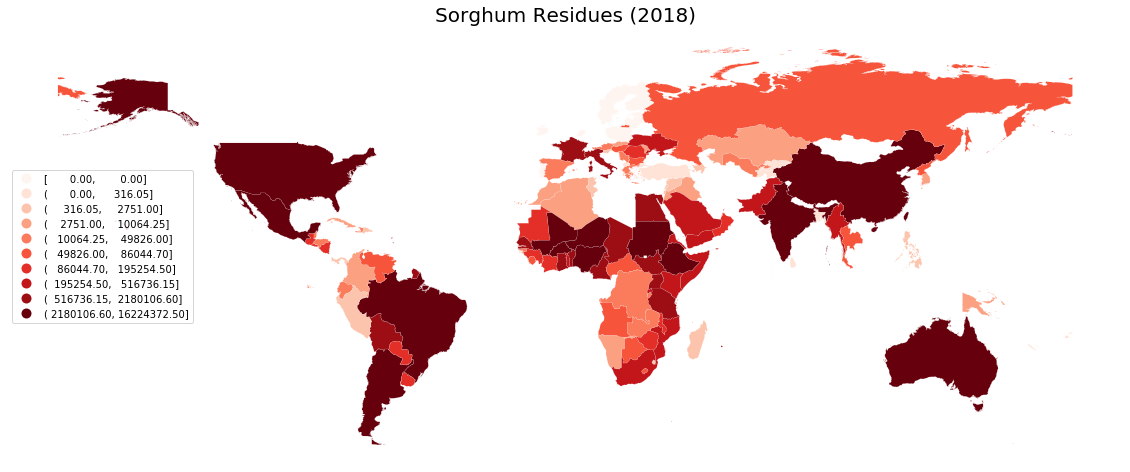

In [14]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
sorghum18_g.plot(column='Sorghum_Residue',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
         )
ax.set_axis_off()
ax.set_title("Sorghum Residues (2018)", fontsize=20)

In [15]:
#fill missing values
#get centriod of each polygon
sorghum18_g["centroid"]=sorghum18_g["geometry"].values.centroid

In [16]:
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([sorghum18_g.loc[i,"centroid"].x,sorghum18_g.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=10)
        sum_r=0
        k=0
        for j in idx:
            if not np.isnan(sorghum18_g.loc[j,"Sorghum_Residue"]):
                k=k+1
                sum_r=sum_r+sorghum18_g.loc[j,"Sorghum_Residue"]
        if k!=0:
            a_sum=sum_r/k
            sorghum18_g.loc[i,"Sorghum_Residue"]=a_sum

while len(sorghum18_g[np.isnan(sorghum18_g["Sorghum_Residue"].values)].index)!=0:
    ckdnearest(sorghum18_g,sorghum18_g[np.isnan(sorghum18_g["Sorghum_Residue"].values)].index)

In [17]:
len(sorghum18_g[np.isnan(sorghum18_g["Sorghum_Residue"].values)])

0

Text(0.5, 1, 'Sorghum Residues (2018)')

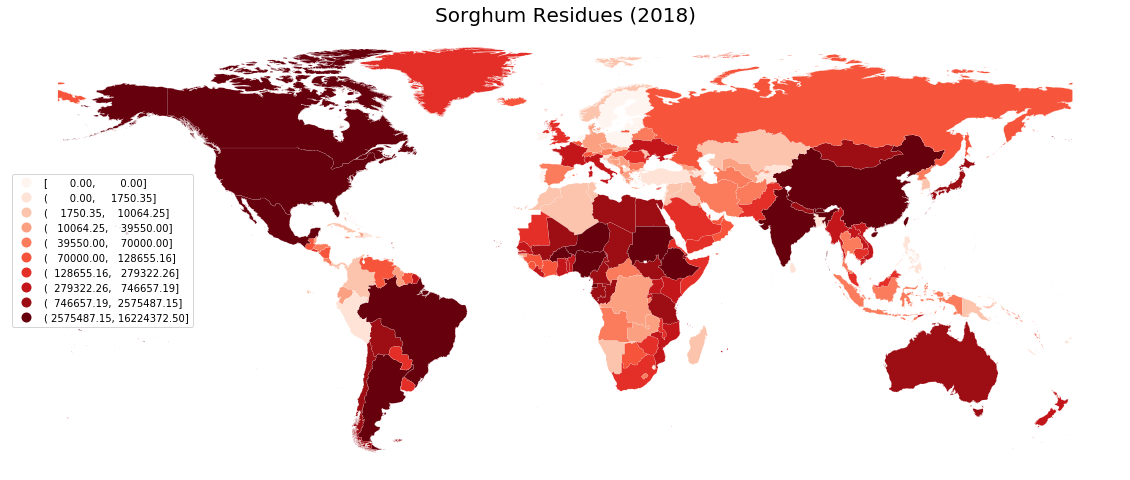

In [18]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
sorghum18_g.plot(column='Sorghum_Residue',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,               
       )
ax.set_axis_off()
ax.set_title("Sorghum Residues (2018)", fontsize=20)

In [19]:
sorghum18_g["Area Code (FAO)"]=sorghum18_g["Country Code"]
sorghum18_g

,Country Code,Country,geometry,CONTINENT,country_area,Area Code (FAO),Sorghum_Residue,centroid
0,2.0,Afghanistan,"POLYGON ((74.54235 37.02167, 74.54742 37.01567...",Asia,6.528600e+05,2.0,6.050479e+04,POINT (66.00845 33.83627)
1,3.0,Albania,"POLYGON ((20.56715 41.87318, 20.54172 41.86158...",Europe,2.875000e+04,3.0,5.028829e+04,POINT (20.05382 41.14248)
2,4.0,Algeria,"POLYGON ((6.58326 36.98981, 6.59946 36.97309, ...",Africa,2.381741e+06,4.0,6.338500e+03,POINT (2.65309 28.14889)
3,5.0,American Samoa,"MULTIPOLYGON (((-170.59101 -14.26483, -170.576...",Oceania,2.000000e+02,5.0,7.929420e+06,POINT (-170.39892 -14.25494)
4,6.0,Andorra,"POLYGON ((1.70701 42.50278, 1.69750 42.49446, ...",Europe,4.700000e+02,6.0,2.828569e+05,POINT (1.56076 42.54133)
5,7.0,Angola,"MULTIPOLYGON (((13.07370 -4.63532, 13.06533 -4...",Africa,1.246700e+06,7.0,6.962900e+04,POINT (17.53699 -12.29232)
6,258.0,Anguilla,"MULTIPOLYGON (((-63.00739 18.27302, -62.98400 ...",North America,1.020000e+02,258.0,0.000000e+00,POINT (-63.05857 18.22569)
7,8.0,Antigua and Barbuda,"MULTIPOLYGON (((-61.88362 17.04902, -61.87922 ...",North America,4.400000e+02,8.0,0.000000e+00,POINT (-61.79173 17.28438)
8,9.0,Argentina,"MULTIPOLYGON (((-67.28475 -23.83414, -67.25133...",South America,2.780400e+06,9.0,2.736029e+06,POINT (-65.17819 -35.38755)
9,1.0,Armenia,"MULTIPOLYGON (((45.00240 41.29045, 45.03940 41...",Asia,2.974000e+04,1.0,2.331292e+03,POINT (44.93230 40.28813)


In [20]:
#do spatial analysis
#global spatial analysis
sorghum18_gs=sorghum18_g
sorghum_binary=[]
for i in range(0,sorghum18_gs.shape[0]):
    sorghum_binary.append(sorghum18_gs.loc[i,'Sorghum_Residue']> sorghum18_gs['Sorghum_Residue'].median())

In [21]:
labels = ['Low value', 'High value']
sorghum_binary= [labels[i] for i in 1*sorghum_binary] 
sorghum18_gs['sorghum_binary'] = sorghum_binary

Text(0.5, 1, 'High and Low Values of Sorghum Residues (2018)')

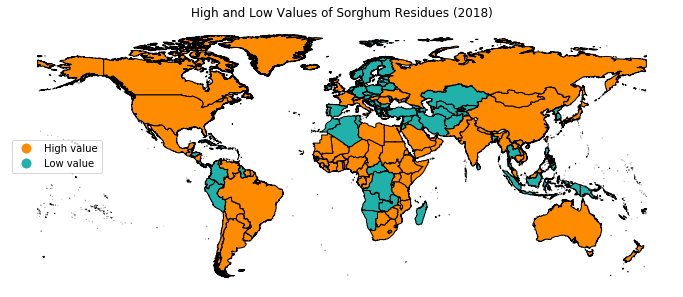

In [22]:
#visualize high and low values
from matplotlib import colors
fig = plt.figure(figsize=(12,10))
ax = plt.gca()
cmap = colors.ListedColormap(['darkorange', 'lightseagreen'])  
sorghum18_gs.plot(column='sorghum_binary', cmap=cmap ,edgecolor='black', legend=True,legend_kwds=dict(loc='center left'), ax=ax)
ax.set_axis_off()
ax.set_title("High and Low Values of Sorghum Residues (2018)")

In [23]:
#global autocorrelation
from pysal.explore import esda 
sorghum_18gx_binary = 1 * (sorghum18_gs['Sorghum_Residue']>sorghum18_gs['Sorghum_Residue'].median()) # convert back to binary
sorghum_W_queen = lps.weights.Queen.from_dataframe(sorghum18_gs)
sorghum_W_queen.transform = 'b'
sorghum_jc = esda.join_counts.Join_Counts(sorghum_18gx_binary,sorghum_W_queen)

('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 7, ' is an island (no neighbors)')
('WARNING: ', 10, ' is an island (no neighbors)')
('WARNING: ', 11, ' is an island (no neighbors)')
('WARNING: ', 14, ' is an island (no neighbors)')
('WARNING: ', 15, ' is an island (no neighbors)')
('WARNING: ', 17, ' is an island (no neighbors)')
('WARNING: ', 22, ' is an island (no neighbors)')
('WARNING: ', 28, ' is an island (no neighbors)')
('WARNING: ', 33, ' is an island (no neighbors)')
('WARNING: ', 37, ' is an island (no neighbors)')
('WARNING: ', 43, ' is an island (no neighbors)')
('WARNING: ', 45, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 51, ' is an island (no neighbors)')
('WARNING: ', 52, ' is an island (no neighbors)')
('WARNING: ', 58, ' is an island (no neighbors)')
('WARNING: ', 68, ' is an island (no neighbors)')
('WARNING: ', 69, ' is an island (no neighbors)')
('W

Text(0.5, 0, "Moran's I")

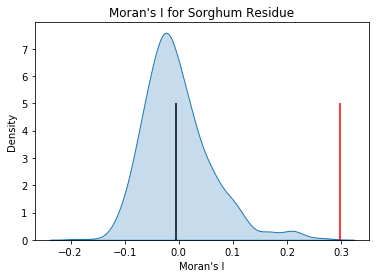

In [24]:
sorghum_mi = esda.moran.Moran(sorghum18_gs['Sorghum_Residue'],sorghum_W_queen)
sns.kdeplot(sorghum_mi.sim, shade=True)
plt.vlines(sorghum_mi.I, 0, 5, color='r')
plt.vlines(sorghum_mi.EI, 0, 5)
plt.title("Moran's I for Sorghum Residue")
plt.xlabel("Moran's I")

In [25]:
# Check the statistical significance
sorghum_mi.p_sim

0.001

In [26]:
sorghum_w_queen = Queen.from_dataframe(sorghum18_gs)

In [27]:
I_price = ps.explore.esda.Moran(sorghum18_gs['Sorghum_Residue'].values, sorghum_w_queen)  # Moran's I
I_price.I, I_price.p_sim 

('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 7, ' is an island (no neighbors)')
('WARNING: ', 10, ' is an island (no neighbors)')
('WARNING: ', 11, ' is an island (no neighbors)')
('WARNING: ', 14, ' is an island (no neighbors)')
('WARNING: ', 15, ' is an island (no neighbors)')
('WARNING: ', 17, ' is an island (no neighbors)')
('WARNING: ', 22, ' is an island (no neighbors)')
('WARNING: ', 28, ' is an island (no neighbors)')
('WARNING: ', 33, ' is an island (no neighbors)')
('WARNING: ', 37, ' is an island (no neighbors)')
('WARNING: ', 43, ' is an island (no neighbors)')
('WARNING: ', 45, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 51, ' is an island (no neighbors)')
('WARNING: ', 52, ' is an island (no neighbors)')
('WARNING: ', 58, ' is an island (no neighbors)')
('WARNING: ', 68, ' is an island (no neighbors)')
('WARNING: ', 69, ' is an island (no neighbors)')
('W

(0.29886954739138066, 0.001)

In [28]:
#local spatial autocorrelation
sorghum_lisa = ps.explore.esda.Moran_Local(sorghum18_gs['Sorghum_Residue'].values,sorghum_W_queen, permutations=999)

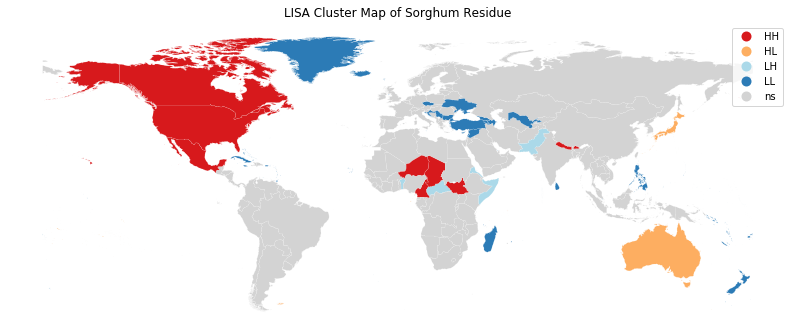

In [29]:
from pysal.viz.splot.esda import lisa_cluster
fig, ax=plt.subplots(1, figsize=(14,10))
fig = lisa_cluster(sorghum_lisa,sorghum18_gs, ax=ax)
plt.title("LISA Cluster Map of Sorghum Residue")
plt.show() 

In [30]:
sorghum18_gs['lag_sorghum'] = ps.lib.weights.lag_spatial(sorghum_W_queen, sorghum18_gs['Sorghum_Residue'])
sigs = sorghum18_gs['Sorghum_Residue'][sorghum_lisa.p_sim <= .05]
W_sigs = sorghum18_gs['lag_sorghum'][sorghum_lisa.p_sim <= .05]
insigs = sorghum18_gs['Sorghum_Residue'][sorghum_lisa.p_sim > .05]
W_insigs = sorghum18_gs['lag_sorghum'][sorghum_lisa.p_sim > .05]

Text(0.5, 0, 'Sorghum Value(2018)')

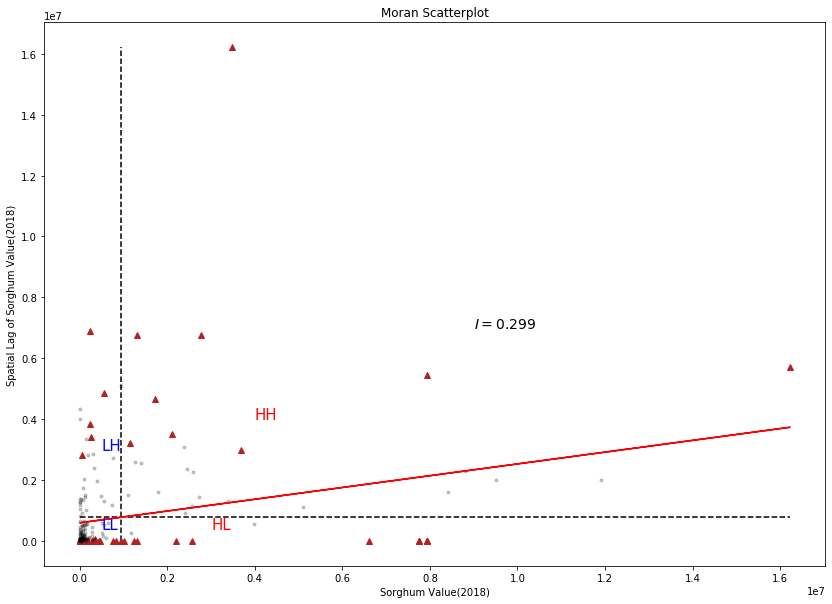

In [31]:
b,a = np.polyfit(sorghum18_gs['Sorghum_Residue'], sorghum18_gs['lag_sorghum'], 1)
moran=ps.explore.esda.Moran(sorghum18_gs['Sorghum_Residue'].values, sorghum_W_queen)

fig, ax=plt.subplots(1, figsize=(14,10))
plt.plot(sigs, W_sigs, '^', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
 # dashed vert at mean of the last year's PCI
plt.vlines(sorghum18_gs['Sorghum_Residue'].mean(), sorghum18_gs['lag_sorghum'].min(), sorghum18_gs['lag_sorghum'].max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(sorghum18_gs['lag_sorghum'].mean(), sorghum18_gs['Sorghum_Residue'].min(), sorghum18_gs['Sorghum_Residue'].max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(sorghum18_gs['Sorghum_Residue'], a + b*sorghum18_gs['Sorghum_Residue'], 'r')
plt.text(s='$I = %.3f$' % moran.I, x=9000000, y=7000000, fontsize=14)
plt.text(4000000, 4000000, "HH", fontsize=15, color='r')
plt.text(3000000, 400000, "HL", fontsize=15, color='r')
plt.text(500000,3000000, "LH", fontsize=15, color='b')
plt.text(500000, 400000, "LL", fontsize=15, color='b')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Sorghum Value(2018)')
plt.xlabel('Sorghum Value(2018)')

In [32]:
#do prediction
#read fertilizer csv 
fertilizers_18=pd.read_csv("dataset/fertilizer/synthetic_fertilizers_per_area_2018.csv",usecols=["Area Code (FAO)","Ferti_Value"])

In [33]:
#merge fertilizer data
sorghum18_g1=pd.merge(sorghum18_g,fertilizers_18,on="Area Code (FAO)",how="outer")
sorghum18_g1["Area Code (FAO)"]=sorghum18_g1["Country Code"]

In [34]:
#fill fertilizer missing values 
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([gdA.loc[i,"centroid"].x,gdA.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=4)
        sum_r=0
        k=0
        for j in idx:
            if not np.isnan(gdA.loc[j,"Ferti_Value"]):
                k=k+1
                sum_r=sum_r+gdA.loc[j,"Ferti_Value"]
        if k!=0:
            a_sum=sum_r/k
            gdA.loc[i,"Ferti_Value"]=a_sum
while len(sorghum18_g1[np.isnan(sorghum18_g1["Ferti_Value"].values)].index)!=0:
    ckdnearest(sorghum18_g1,sorghum18_g1[np.isnan(sorghum18_g1["Ferti_Value"].values)].index)

In [35]:
#read csv 
cropland_18=pd.read_csv("dataset/cropland/crop_land_2018.csv",usecols=["Area Code (FAO)","Land_Value"])
cropland_18.head()

,Area Code (FAO),Land_Value
0,3,3050.6290
1,7,5471.1183
2,9,27913.0415
3,10,52921.9173
4,11,2626.2094


In [36]:
sorghum18_g2=pd.merge(sorghum18_g1,cropland_18,on="Area Code (FAO)",how="outer")

In [37]:
#fill crop land missing values 
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([gdA.loc[i,"centroid"].x,gdA.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=5)
        land_sum=0
        area_sum=0
        k=0
        for j in idx:
            if not np.isnan(gdA.loc[j,"Land_Value"]):
                land_sum=land_sum+gdA.loc[j,"Land_Value"]
                area_sum=area_sum+gdA.loc[j,"country_area"]
                k=k+1
        if k!=0:
            gdA.loc[i,"Land_Value"]=(land_sum/area_sum)*gdA.loc[i,"country_area"]
while len(sorghum18_g2[np.isnan(sorghum18_g2["Land_Value"].values)].index)!=0:
    ckdnearest(sorghum18_g2,sorghum18_g2[np.isnan(sorghum18_g2["Land_Value"].values)].index)

In [38]:
sorghum18_g2

,Country Code,Country,geometry,CONTINENT,country_area,Area Code (FAO),Sorghum_Residue,centroid,sorghum_binary,lag_sorghum,Ferti_Value,Land_Value
0,2.0,Afghanistan,"POLYGON ((74.54235 37.02167, 74.54742 37.01567...",Asia,6.528600e+05,2.0,6.050479e+04,POINT (66.00845 33.83627),Low value,9.119580e+05,5.886300,1.683642e+04
1,3.0,Albania,"POLYGON ((20.56715 41.87318, 20.54172 41.86158...",Europe,2.875000e+04,3.0,5.028829e+04,POINT (20.05382 41.14248),Low value,1.236442e+04,35.587700,3.050629e+03
2,4.0,Algeria,"POLYGON ((6.58326 36.98981, 6.59946 36.97309, ...",Africa,2.381741e+06,4.0,6.338500e+03,POINT (2.65309 28.14889),Low value,1.195377e+06,8.242300,4.104448e+04
3,5.0,American Samoa,"MULTIPOLYGON (((-170.59101 -14.26483, -170.576...",Oceania,2.000000e+02,5.0,7.929420e+06,POINT (-170.39892 -14.25494),High value,0.000000e+00,0.160700,6.321889e+00
4,6.0,Andorra,"POLYGON ((1.70701 42.50278, 1.69750 42.49446, ...",Europe,4.700000e+02,6.0,2.828569e+05,POINT (1.56076 42.54133),High value,2.999675e+05,89.569450,7.308600e+01
5,7.0,Angola,"MULTIPOLYGON (((13.07370 -4.63532, 13.06533 -4...",Africa,1.246700e+06,7.0,6.962900e+04,POINT (17.53699 -12.29232),Low value,6.105521e+05,4.207600,5.471118e+03
6,258.0,Anguilla,"MULTIPOLYGON (((-63.00739 18.27302, -62.98400 ...",North America,1.020000e+02,258.0,0.000000e+00,POINT (-63.05857 18.22569),Low value,0.000000e+00,1.718000,2.234238e+02
7,8.0,Antigua and Barbuda,"MULTIPOLYGON (((-61.88362 17.04902, -61.87922 ...",North America,4.400000e+02,8.0,0.000000e+00,POINT (-61.79173 17.28438),Low value,0.000000e+00,1.718000,9.637889e+02
8,9.0,Argentina,"MULTIPOLYGON (((-67.28475 -23.83414, -67.25133...",South America,2.780400e+06,9.0,2.736029e+06,POINT (-65.17819 -35.38755),High value,1.442813e+06,28.819900,2.791304e+04
9,1.0,Armenia,"MULTIPOLYGON (((45.00240 41.29045, 45.03940 41...",Asia,2.974000e+04,1.0,2.331292e+03,POINT (44.93230 40.28813),Low value,1.838162e+04,178.534400,5.176354e-01


In [39]:
#read climate data
temperature_18=pd.read_csv("dataset/climate/climate18.csv",usecols=["temperature_mean_Sorghum","temperature_max","temperature_min","Country Code"])
temperature_18.head()

,temperature_max,temperature_min,Country Code,temperature_mean_Sorghum
0,30.82,15.20,101.0,26.880
1,28.62,21.06,131.0,26.190
2,28.51,-11.78,40.0,6.575
3,32.75,-12.02,19.0,25.360
4,37.17,0.07,170.0,24.855


In [40]:
sorghum18_g3=pd.merge(sorghum18_g2,temperature_18,on="Country Code",how="outer")
sorghum18_g3=sorghum18_g3.drop([227,228,229,230])
sorghum18_g3

,Country Code,Country,geometry,CONTINENT,country_area,Area Code (FAO),Sorghum_Residue,centroid,sorghum_binary,lag_sorghum,Ferti_Value,Land_Value,temperature_max,temperature_min,temperature_mean_Sorghum
0,2.0,Afghanistan,"POLYGON ((74.54235 37.02167, 74.54742 37.01567...",Asia,6.528600e+05,2.0,6.050479e+04,POINT (66.00845 33.83627),Low value,9.119580e+05,5.886300,1.683642e+04,26.80,-11.47,13.870
1,3.0,Albania,"POLYGON ((20.56715 41.87318, 20.54172 41.86158...",Europe,2.875000e+04,3.0,5.028829e+04,POINT (20.05382 41.14248),Low value,1.236442e+04,35.587700,3.050629e+03,17.65,10.01,11.925
2,4.0,Algeria,"POLYGON ((6.58326 36.98981, 6.59946 36.97309, ...",Africa,2.381741e+06,4.0,6.338500e+03,POINT (2.65309 28.14889),Low value,1.195377e+06,8.242300,4.104448e+04,29.87,10.59,25.150
3,5.0,American Samoa,"MULTIPOLYGON (((-170.59101 -14.26483, -170.576...",Oceania,2.000000e+02,5.0,7.929420e+06,POINT (-170.39892 -14.25494),High value,0.000000e+00,0.160700,6.321889e+00,NaN,NaN,NaN
4,6.0,Andorra,"POLYGON ((1.70701 42.50278, 1.69750 42.49446, ...",Europe,4.700000e+02,6.0,2.828569e+05,POINT (1.56076 42.54133),High value,2.999675e+05,89.569450,7.308600e+01,NaN,NaN,NaN
5,7.0,Angola,"MULTIPOLYGON (((13.07370 -4.63532, 13.06533 -4...",Africa,1.246700e+06,7.0,6.962900e+04,POINT (17.53699 -12.29232),Low value,6.105521e+05,4.207600,5.471118e+03,27.65,18.71,23.705
6,258.0,Anguilla,"MULTIPOLYGON (((-63.00739 18.27302, -62.98400 ...",North America,1.020000e+02,258.0,0.000000e+00,POINT (-63.05857 18.22569),Low value,0.000000e+00,1.718000,2.234238e+02,NaN,NaN,NaN
7,8.0,Antigua and Barbuda,"MULTIPOLYGON (((-61.88362 17.04902, -61.87922 ...",North America,4.400000e+02,8.0,0.000000e+00,POINT (-61.79173 17.28438),Low value,0.000000e+00,1.718000,9.637889e+02,NaN,NaN,NaN
8,9.0,Argentina,"MULTIPOLYGON (((-67.28475 -23.83414, -67.25133...",South America,2.780400e+06,9.0,2.736029e+06,POINT (-65.17819 -35.38755),High value,1.442813e+06,28.819900,2.791304e+04,26.93,-10.92,15.820
9,1.0,Armenia,"MULTIPOLYGON (((45.00240 41.29045, 45.03940 41...",Asia,2.974000e+04,1.0,2.331292e+03,POINT (44.93230 40.28813),Low value,1.838162e+04,178.534400,5.176354e-01,14.74,6.13,9.910


In [41]:
#fill temperature missing values median
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([gdA.loc[i,"centroid"].x,gdA.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=4)
        t_sum=0
        k=0
        for j in idx:
            if not np.isnan(gdA.loc[j,"temperature_mean_Sorghum"]):
                k=k+1
                t_sum=t_sum+gdA.loc[j,"temperature_mean_Sorghum"]
        if k!=0:
            a_sum=t_sum/k
            gdA.loc[i,"temperature_mean_Sorghum"]=a_sum
            
while len(sorghum18_g3[np.isnan(sorghum18_g3["temperature_mean_Sorghum"].values)].index)!=0:
    ckdnearest(sorghum18_g3,sorghum18_g3[np.isnan(sorghum18_g3["temperature_mean_Sorghum"].values)].index)

In [42]:
#fill temperature missing values max
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([gdA.loc[i,"centroid"].x,gdA.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=4)
        t_sum=0
        k=0
        for j in idx:
            if not np.isnan(gdA.loc[j,"temperature_max"]):
                k=k+1
                t_sum=t_sum+gdA.loc[j,"temperature_max"]
        if k!=0:
            a_sum=t_sum/k
            gdA.loc[i,"temperature_max"]=a_sum
            
while len(sorghum18_g3[np.isnan(sorghum18_g3["temperature_max"].values)].index)!=0:
    ckdnearest(sorghum18_g3,sorghum18_g3[np.isnan(sorghum18_g3["temperature_max"].values)].index)

In [43]:
#fill temperature missing values min
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([gdA.loc[i,"centroid"].x,gdA.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=4)
        t_sum=0
        k=0
        for j in idx:
            if not np.isnan(gdA.loc[j,"temperature_min"]):
                k=k+1
                t_sum=t_sum+gdA.loc[j,"temperature_min"]
        if k!=0:
            a_sum=t_sum/k
            gdA.loc[i,"temperature_min"]=a_sum
while len(sorghum18_g3[np.isnan(sorghum18_g3["temperature_min"].values)].index)!=0:
    ckdnearest(sorghum18_g3,sorghum18_g3[np.isnan(sorghum18_g3["temperature_min"].values)].index)

In [44]:
sorghum18_g3

,Country Code,Country,geometry,CONTINENT,country_area,Area Code (FAO),Sorghum_Residue,centroid,sorghum_binary,lag_sorghum,Ferti_Value,Land_Value,temperature_max,temperature_min,temperature_mean_Sorghum
0,2.0,Afghanistan,"POLYGON ((74.54235 37.02167, 74.54742 37.01567...",Asia,6.528600e+05,2.0,6.050479e+04,POINT (66.00845 33.83627),Low value,9.119580e+05,5.886300,1.683642e+04,26.800000,-11.470000,13.870000
1,3.0,Albania,"POLYGON ((20.56715 41.87318, 20.54172 41.86158...",Europe,2.875000e+04,3.0,5.028829e+04,POINT (20.05382 41.14248),Low value,1.236442e+04,35.587700,3.050629e+03,17.650000,10.010000,11.925000
2,4.0,Algeria,"POLYGON ((6.58326 36.98981, 6.59946 36.97309, ...",Africa,2.381741e+06,4.0,6.338500e+03,POINT (2.65309 28.14889),Low value,1.195377e+06,8.242300,4.104448e+04,29.870000,10.590000,25.150000
3,5.0,American Samoa,"MULTIPOLYGON (((-170.59101 -14.26483, -170.576...",Oceania,2.000000e+02,5.0,7.929420e+06,POINT (-170.39892 -14.25494),High value,0.000000e+00,0.160700,6.321889e+00,16.410000,3.820000,11.525000
4,6.0,Andorra,"POLYGON ((1.70701 42.50278, 1.69750 42.49446, ...",Europe,4.700000e+02,6.0,2.828569e+05,POINT (1.56076 42.54133),High value,2.999675e+05,89.569450,7.308600e+01,25.440000,6.045000,13.430000
5,7.0,Angola,"MULTIPOLYGON (((13.07370 -4.63532, 13.06533 -4...",Africa,1.246700e+06,7.0,6.962900e+04,POINT (17.53699 -12.29232),Low value,6.105521e+05,4.207600,5.471118e+03,27.650000,18.710000,23.705000
6,258.0,Anguilla,"MULTIPOLYGON (((-63.00739 18.27302, -62.98400 ...",North America,1.020000e+02,258.0,0.000000e+00,POINT (-63.05857 18.22569),Low value,0.000000e+00,1.718000,2.234238e+02,12.140000,10.820000,11.660000
7,8.0,Antigua and Barbuda,"MULTIPOLYGON (((-61.88362 17.04902, -61.87922 ...",North America,4.400000e+02,8.0,0.000000e+00,POINT (-61.79173 17.28438),Low value,0.000000e+00,1.718000,9.637889e+02,12.140000,10.820000,11.660000
8,9.0,Argentina,"MULTIPOLYGON (((-67.28475 -23.83414, -67.25133...",South America,2.780400e+06,9.0,2.736029e+06,POINT (-65.17819 -35.38755),High value,1.442813e+06,28.819900,2.791304e+04,26.930000,-10.920000,15.820000
9,1.0,Armenia,"MULTIPOLYGON (((45.00240 41.29045, 45.03940 41...",Asia,2.974000e+04,1.0,2.331292e+03,POINT (44.93230 40.28813),Low value,1.838162e+04,178.534400,5.176354e-01,14.740000,6.130000,9.910000


In [45]:
#read rainfall data
rainfall_18=pd.read_csv("dataset/climate/rainfall_18.csv",usecols=["Sorghum_rainfall_mean","rainfall_max","rainfall_min","Country Code"])
rainfall_18.head()

,rainfall_max,rainfall_min,Country Code,Sorghum_rainfall_mean
0,5763.3,1070.8,101.0,2730.9
1,4889.3,2002.7,131.0,3022.9
2,3518.3,18.8,40.0,523.7
3,4620.9,107.8,19.0,1175.9
4,5273.9,6.0,170.0,1556.3


In [46]:
sorghum18_g4=pd.merge(sorghum18_g3,rainfall_18,on="Country Code",how="outer")
sorghum18_g4=sorghum18_g4.drop([227,228,229,230])
sorghum18_g4

,Country Code,Country,geometry,CONTINENT,country_area,Area Code (FAO),Sorghum_Residue,centroid,sorghum_binary,lag_sorghum,Ferti_Value,Land_Value,temperature_max,temperature_min,temperature_mean_Sorghum,rainfall_max,rainfall_min,Sorghum_rainfall_mean
0,2.0,Afghanistan,"POLYGON ((74.54235 37.02167, 74.54742 37.01567...",Asia,6.528600e+05,2.0,6.050479e+04,POINT (66.00845 33.83627),Low value,9.119580e+05,5.886300,1.683642e+04,26.800000,-11.470000,13.870000,1558.7,4.3,430.40
1,3.0,Albania,"POLYGON ((20.56715 41.87318, 20.54172 41.86158...",Europe,2.875000e+04,3.0,5.028829e+04,POINT (20.05382 41.14248),Low value,1.236442e+04,35.587700,3.050629e+03,17.650000,10.010000,11.925000,1683.5,981.5,1146.90
2,4.0,Algeria,"POLYGON ((6.58326 36.98981, 6.59946 36.97309, ...",Africa,2.381741e+06,4.0,6.338500e+03,POINT (2.65309 28.14889),Low value,1.195377e+06,8.242300,4.104448e+04,29.870000,10.590000,25.150000,987.7,9.1,59.40
3,5.0,American Samoa,"MULTIPOLYGON (((-170.59101 -14.26483, -170.576...",Oceania,2.000000e+02,5.0,7.929420e+06,POINT (-170.39892 -14.25494),High value,0.000000e+00,0.160700,6.321889e+00,16.410000,3.820000,11.525000,NaN,NaN,NaN
4,6.0,Andorra,"POLYGON ((1.70701 42.50278, 1.69750 42.49446, ...",Europe,4.700000e+02,6.0,2.828569e+05,POINT (1.56076 42.54133),High value,2.999675e+05,89.569450,7.308600e+01,25.440000,6.045000,13.430000,NaN,NaN,NaN
5,7.0,Angola,"MULTIPOLYGON (((13.07370 -4.63532, 13.06533 -4...",Africa,1.246700e+06,7.0,6.962900e+04,POINT (17.53699 -12.29232),Low value,6.105521e+05,4.207600,5.471118e+03,27.650000,18.710000,23.705000,2184.4,1.0,1063.85
6,258.0,Anguilla,"MULTIPOLYGON (((-63.00739 18.27302, -62.98400 ...",North America,1.020000e+02,258.0,0.000000e+00,POINT (-63.05857 18.22569),Low value,0.000000e+00,1.718000,2.234238e+02,12.140000,10.820000,11.660000,NaN,NaN,NaN
7,8.0,Antigua and Barbuda,"MULTIPOLYGON (((-61.88362 17.04902, -61.87922 ...",North America,4.400000e+02,8.0,0.000000e+00,POINT (-61.79173 17.28438),Low value,0.000000e+00,1.718000,9.637889e+02,12.140000,10.820000,11.660000,NaN,NaN,NaN
8,9.0,Argentina,"MULTIPOLYGON (((-67.28475 -23.83414, -67.25133...",South America,2.780400e+06,9.0,2.736029e+06,POINT (-65.17819 -35.38755),High value,1.442813e+06,28.819900,2.791304e+04,26.930000,-10.920000,15.820000,2347.6,114.2,577.30
9,1.0,Armenia,"MULTIPOLYGON (((45.00240 41.29045, 45.03940 41...",Asia,2.974000e+04,1.0,2.331292e+03,POINT (44.93230 40.28813),Low value,1.838162e+04,178.534400,5.176354e-01,14.740000,6.130000,9.910000,623.7,390.9,595.20


In [47]:
#fill rainfall missing values 
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([gdA.loc[i,"centroid"].x,gdA.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=4)
        t_sum=0
        k=0
        for j in idx:
            if not np.isnan(gdA.loc[j,"Sorghum_rainfall_mean"]):
                k=k+1
                t_sum=t_sum+gdA.loc[j,"Sorghum_rainfall_mean"]
        if k!=0:
            a_sum=t_sum/k
            gdA.loc[i,"Sorghum_rainfall_mean"]=a_sum
            
while len(sorghum18_g4[np.isnan(sorghum18_g4["Sorghum_rainfall_mean"].values)].index)!=0:
    ckdnearest(sorghum18_g4,sorghum18_g4[np.isnan(sorghum18_g4["Sorghum_rainfall_mean"].values)].index)

In [48]:
#fill rainfall missing values  max
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([gdA.loc[i,"centroid"].x,gdA.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=4)
        t_sum=0
        k=0
        for j in idx:
            if not np.isnan(gdA.loc[j,"rainfall_max"]):
                k=k+1
                t_sum=t_sum+gdA.loc[j,"rainfall_max"]
        if k!=0:
            a_sum=t_sum/k
            gdA.loc[i,"rainfall_max"]=a_sum
            
while len(sorghum18_g4[np.isnan(sorghum18_g4["rainfall_max"].values)].index)!=0:
    ckdnearest(sorghum18_g4,sorghum18_g4[np.isnan(sorghum18_g4["rainfall_max"].values)].index)

In [49]:
#fill rainfall missing values  min
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([gdA.loc[i,"centroid"].x,gdA.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=4)
        t_sum=0
        k=0
        for j in idx:
            if not np.isnan(gdA.loc[j,"rainfall_min"]):
                k=k+1
                t_sum=t_sum+gdA.loc[j,"rainfall_min"]
        if k!=0:
            a_sum=t_sum/k
            gdA.loc[i,"rainfall_min"]=a_sum
            
while len(sorghum18_g4[np.isnan(sorghum18_g4["rainfall_min"].values)].index)!=0:
    ckdnearest(sorghum18_g4,sorghum18_g4[np.isnan(sorghum18_g4["rainfall_min"].values)].index)

In [50]:
sorghum18_g4

,Country Code,Country,geometry,CONTINENT,country_area,Area Code (FAO),Sorghum_Residue,centroid,sorghum_binary,lag_sorghum,Ferti_Value,Land_Value,temperature_max,temperature_min,temperature_mean_Sorghum,rainfall_max,rainfall_min,Sorghum_rainfall_mean
0,2.0,Afghanistan,"POLYGON ((74.54235 37.02167, 74.54742 37.01567...",Asia,6.528600e+05,2.0,6.050479e+04,POINT (66.00845 33.83627),Low value,9.119580e+05,5.886300,1.683642e+04,26.800000,-11.470000,13.870000,1558.700000,4.300000,430.400000
1,3.0,Albania,"POLYGON ((20.56715 41.87318, 20.54172 41.86158...",Europe,2.875000e+04,3.0,5.028829e+04,POINT (20.05382 41.14248),Low value,1.236442e+04,35.587700,3.050629e+03,17.650000,10.010000,11.925000,1683.500000,981.500000,1146.900000
2,4.0,Algeria,"POLYGON ((6.58326 36.98981, 6.59946 36.97309, ...",Africa,2.381741e+06,4.0,6.338500e+03,POINT (2.65309 28.14889),Low value,1.195377e+06,8.242300,4.104448e+04,29.870000,10.590000,25.150000,987.700000,9.100000,59.400000
3,5.0,American Samoa,"MULTIPOLYGON (((-170.59101 -14.26483, -170.576...",Oceania,2.000000e+02,5.0,7.929420e+06,POINT (-170.39892 -14.25494),High value,0.000000e+00,0.160700,6.321889e+00,16.410000,3.820000,11.525000,3938.250000,1912.050000,2319.600000
4,6.0,Andorra,"POLYGON ((1.70701 42.50278, 1.69750 42.49446, ...",Europe,4.700000e+02,6.0,2.828569e+05,POINT (1.56076 42.54133),High value,2.999675e+05,89.569450,7.308600e+01,25.440000,6.045000,13.430000,2493.050000,452.900000,787.950000
5,7.0,Angola,"MULTIPOLYGON (((13.07370 -4.63532, 13.06533 -4...",Africa,1.246700e+06,7.0,6.962900e+04,POINT (17.53699 -12.29232),Low value,6.105521e+05,4.207600,5.471118e+03,27.650000,18.710000,23.705000,2184.400000,1.000000,1063.850000
6,258.0,Anguilla,"MULTIPOLYGON (((-63.00739 18.27302, -62.98400 ...",North America,1.020000e+02,258.0,0.000000e+00,POINT (-63.05857 18.22569),Low value,0.000000e+00,1.718000,2.234238e+02,12.140000,10.820000,11.660000,664.700000,584.700000,598.600000
7,8.0,Antigua and Barbuda,"MULTIPOLYGON (((-61.88362 17.04902, -61.87922 ...",North America,4.400000e+02,8.0,0.000000e+00,POINT (-61.79173 17.28438),Low value,0.000000e+00,1.718000,9.637889e+02,12.140000,10.820000,11.660000,664.700000,584.700000,598.600000
8,9.0,Argentina,"MULTIPOLYGON (((-67.28475 -23.83414, -67.25133...",South America,2.780400e+06,9.0,2.736029e+06,POINT (-65.17819 -35.38755),High value,1.442813e+06,28.819900,2.791304e+04,26.930000,-10.920000,15.820000,2347.600000,114.200000,577.300000
9,1.0,Armenia,"MULTIPOLYGON (((45.00240 41.29045, 45.03940 41...",Asia,2.974000e+04,1.0,2.331292e+03,POINT (44.93230 40.28813),Low value,1.838162e+04,178.534400,5.176354e-01,14.740000,6.130000,9.910000,623.700000,390.900000,595.200000


In [52]:
sorghum18_g4.to_csv("dataset/crop_residue_and _indicators/sorghum_residue_indicators.csv",columns=["Country Code","Country","CONTINENT","Sorghum_Residue","country_area","Ferti_Value","Land_Value",
                                                                 "temperature_max","temperature_min","temperature_mean_Sorghum",
                                                                "rainfall_max","rainfall_min", "Sorghum_rainfall_mean"])

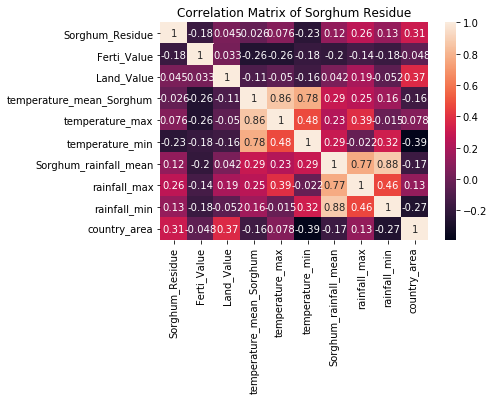

In [53]:
#do prediction
#do coefficient matrix
sorghum_df= pd.DataFrame(sorghum18_g4,columns=['Sorghum_Residue','Ferti_Value',"Land_Value","temperature_mean_Sorghum",
                                             "temperature_max","temperature_min","Sorghum_rainfall_mean","rainfall_max","rainfall_min","country_area"])
corrMatrix = sorghum_df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.title("Correlation Matrix of Sorghum Residue")
plt.show()

In [54]:
X=sorghum_df[['Ferti_Value',"Land_Value","temperature_max","temperature_min","Sorghum_rainfall_mean","rainfall_max","rainfall_min","country_area"]]
#X=sorghum_df[['Ferti_Value',"Land_Value","temperature_mean_Sorghum", "temperature_max","temperature_min","Sorghum_rainfall_mean","rainfall_max","rainfall_min","country_area"]]
y=sorghum_df[['Sorghum_Residue']]

In [55]:
import statsmodels.api as sm
y= np.array(y) # define output/dependant variable
# Note the difference in argument order
lm = sm.OLS(y, X).fit()
#lm1.summary()
#evaluation
lm_pre_y = lm.predict(X)
print("Ordinary Least Square model:")
#MAE
#print("mean absolute error:", metrics.mean_absolute_error(y_test.values,lm_pre_y.values))
#MSE
print("root mean squared error:", sqrt(metrics.mean_squared_error(y,lm_pre_y)))
#1944365.

Ordinary Least Square model:
root mean squared error: 1944365.8844692642


In [56]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.393
Model:                            OLS   Adj. R-squared (uncentered):              0.371
Method:                 Least Squares   F-statistic:                              17.72
Date:                Fri, 03 Sep 2021   Prob (F-statistic):                    2.65e-20
Time:                        02:13:55   Log-Likelihood:                         -3609.2
No. Observations:                 227   AIC:                                      7234.
Df Residuals:                     219   BIC:                                      7262.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Ferti_Value           -6675.0285   2295.432     -2.908      0.004   -1.12e+04   -2151.063
Land_Value               -0.5308      0.449     -1.183      0.238      -1.415       0.354
temperature_max        4.432e+04   1.78e+04      2.483      0.014    9148.287    7.95e+04
temperature_min       -4.502e+04   1.82e+04     -2.477      0.014   -8.08e+04   -9205.833
Sorghum_rainfall_mean -3106.6407    699.270     -4.443      0.000   -4484.802   -1728.480
rainfall_max           1001.8112    260.992      3.838      0.000     487.434    1516.189
rainfall_min           3016.6898    543.140      5.554      0.000    1946.239    4087.141
country_area              0.2796      0.092      3.034      0.003       0.098       0.461
==============================================================================
Omnibus:                      131.947   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              811.897
Skew:                           2.289   Prob(JB):                    5.00e-177
Kurtosis:                      11.054   Cond. No.                     3.44e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 3.44e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [57]:
#lasso regression
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn import linear_model
lasso=linear_model.Lasso()
lasso.fit(X,y)
lasso_pred=lasso.predict(X)
MSE=mean_squared_error(y,lasso_pred)
print("RMSE:",sqrt(MSE))

RMSE: 1944080.9221390288


In [58]:
#R-squared
lasso.score(X,y)

0.292695846902019

In [59]:
#MLP regressor
regr = MLPRegressor(random_state=1, max_iter=500).fit(X, y)
#predict
mlp_pre_y =regr.predict(X)
#MSE
print("root mean squared error:", sqrt(metrics.mean_squared_error(y,mlp_pre_y)))
## R^2
print("R^2 :",regr.score(X,y))

root mean squared error: 2298792.8995214407
R^2 : 0.011043417795704502


In [60]:
#spatial error model
sorghum_dfg= gpd.GeoDataFrame(sorghum18_g4,columns=['Sorghum_Residue','Ferti_Value',"Land_Value","temperature_max","temperature_min","Sorghum_rainfall_mean","rainfall_max","rainfall_min","country_area","geometry"])
w_queeng = Queen.from_dataframe(sorghum_dfg) 

In [61]:
y_lag=np.array(sorghum_dfg["Sorghum_Residue"].values)
y_lag.shape = (len(y_lag),1)

In [62]:
X_lag= []
X_lag.append(sorghum_df["Ferti_Value"].values) 
X_lag.append(sorghum_df["Land_Value"].values) 
X_lag.append(sorghum_df["temperature_max"].values)
X_lag.append(sorghum_df["temperature_min"].values)
X_lag.append(sorghum_df["Sorghum_rainfall_mean"].values)
X_lag.append(sorghum_df["rainfall_max"].values)
X_lag.append(sorghum_df["rainfall_min"].values)
X_lag.append(sorghum_df["country_area"].values)
X_lag = np.array(X_lag).T

In [63]:
from pysal.model.spreg import ML_Error
spat_err = ML_Error(y_lag,X_lag,w_queeng, name_y='Sorghum_Residue', 
                  name_x=['Ferti_Value',"Land_Value","temperature_max","temperature_min","Sorghum_rainfall_mean","rainfall_max","rainfall_min","country_area"],
                  name_w='w_queeng', name_ds='Sorghum_Residue')
print(spat_err.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :Sorghum_Residue
Weights matrix      :    w_queeng
Dependent Variable  :Sorghum_Residue                Number of Observations:         227
Mean dependent var  : 940670.1774                Number of Variables   :           9
S.D. dependent var  :2316700.7719                Degrees of Freedom    :         218
Pseudo R-squared    :      0.2691
Sigma-square ML     :3457719033381.048                Log likelihood        :   -3602.373
S.E of regression   : 1859494.295                Akaike info criterion :    7222.746
                                                 Schwarz criterion     :    7253.571

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------

In [64]:
from sklearn.metrics import mean_squared_error as mse
sqrt(mse(y, spat_err.predy.flatten()))

1979973.239652157

In [65]:
#projection for 2030
#add temperature change
sorghum_dfg["temperature_max_2030"]=sorghum_dfg["temperature_max"]+0.597
sorghum_dfg["temperature_min_2030"]=sorghum_dfg["temperature_min"]+0.597

In [66]:
X_2030=sorghum_dfg[['Ferti_Value',"Land_Value","temperature_max_2030","temperature_min_2030","Sorghum_rainfall_mean","rainfall_max","rainfall_min","country_area"]]

In [67]:
y_pre_2030=lm.predict(X_2030)

In [68]:
for i in range(0,len(y_pre_2030)):
    if y_pre_2030[i]<0:
         y_pre_2030[i]=(-1)* y_pre_2030[i]

In [69]:
sorghum_dfg["Sorghum_Residue_2030"]=y_pre_2030

Text(0.5, 1, 'Sorghum Residue Quantity (2030)')

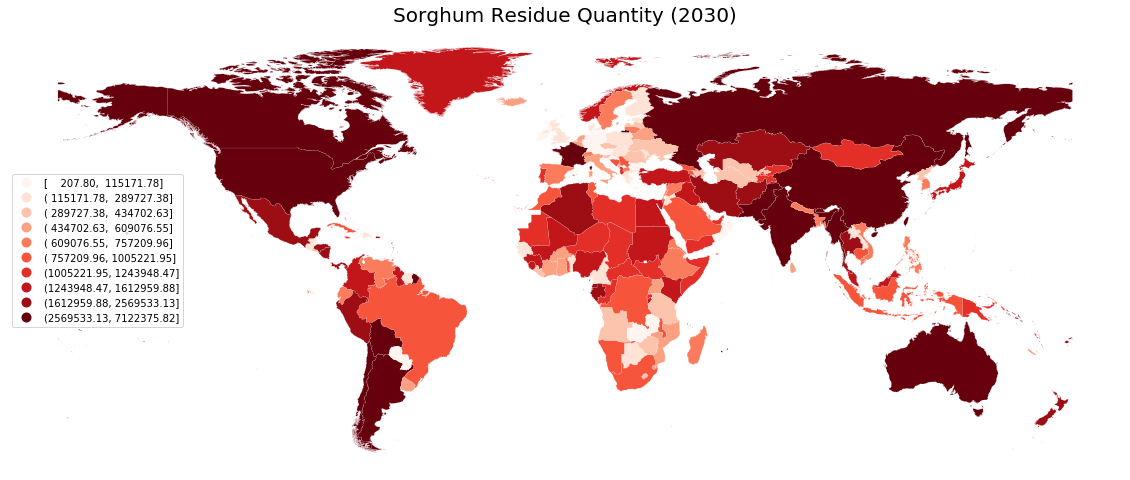

In [70]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
sorghum_dfg.plot(column='Sorghum_Residue_2030',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,               
       )
ax.set_axis_off()
ax.set_title("Sorghum Residue Quantity (2030)", fontsize=20)

In [71]:
#project#projection for 2040
#add temperature change
sorghum_dfg["temperature_max_2040"]=sorghum_dfg["temperature_max"]+0.851
sorghum_dfg["temperature_min_2040"]=sorghum_dfg["temperature_min"]+0.851

In [72]:
X_2040=sorghum_dfg[['Ferti_Value',"Land_Value","temperature_max_2040","temperature_min_2040","Sorghum_rainfall_mean","rainfall_max","rainfall_min","country_area"]]

In [73]:
y_pre_2040=lm.predict(X_2040)

In [74]:
for i in range(0,len(y_pre_2040)):
    if y_pre_2040[i]<0:
         y_pre_2040[i]=(-1)* y_pre_2040[i]

In [75]:
sorghum_dfg["Sorghum_Residue_2040"]=y_pre_2040

Text(0.5, 1, 'Sorghum Residue Quantity (2040)')

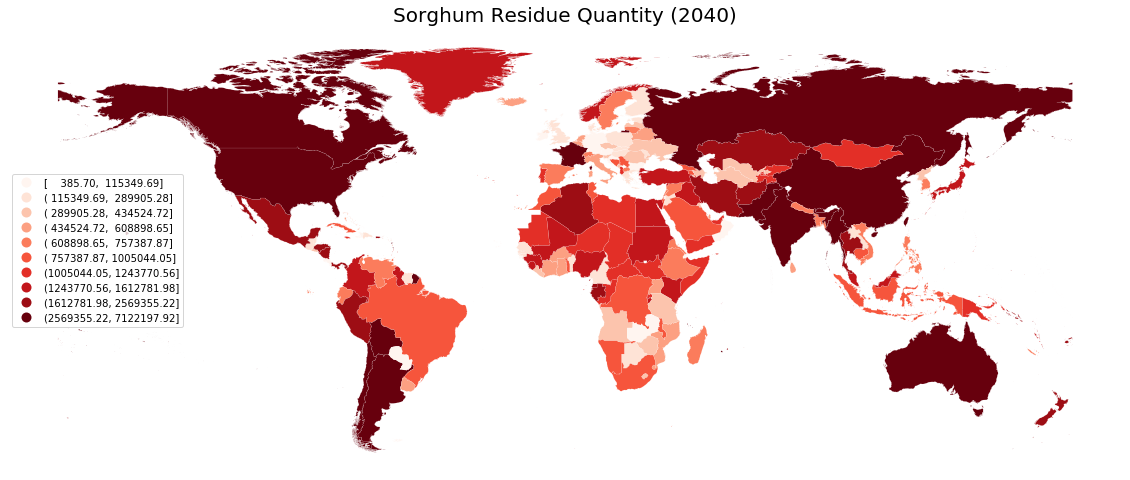

In [76]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
sorghum_dfg.plot(column='Sorghum_Residue_2040',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,               
       )
ax.set_axis_off()
ax.set_title("Sorghum Residue Quantity (2040)", fontsize=20)

In [77]:
#Cellulose
sorghum_dfg["Cellulose_2040"]=sorghum_dfg["Sorghum_Residue_2040"]*0.15

In [78]:
#Hemicellulose
sorghum_dfg["Hemicellulose_2040"]=sorghum_dfg["Sorghum_Residue_2040"]*0.12

In [79]:
#lignin
sorghum_dfg["Lignin_2040"]=sorghum_dfg["Sorghum_Residue_2040"]*0.73

In [80]:
#2030
#Cellulose
sorghum_dfg["Cellulose_2030"]=sorghum_dfg["Sorghum_Residue_2030"]*0.15
#Hemicellulose
sorghum_dfg["Hemicellulose_2030"]=sorghum_dfg["Sorghum_Residue_2030"]*0.12
#lignin
sorghum_dfg["Lignin_2030"]=sorghum_dfg["Sorghum_Residue_2030"]*0.73

In [81]:
sorghum_dfg["Country Code"]=sorghum18_g3['Country Code']

In [82]:
sorghum_dfg.to_csv("dataset/protein/sorghum_protein.csv",columns=["Cellulose_2030","Hemicellulose_2030","Lignin_2030",
                                                                 "Cellulose_2040","Hemicellulose_2040","Lignin_2040",
                                                                 "Country Code"])

In [83]:
diff_2040=sorghum_dfg["Sorghum_Residue_2040"]-sorghum_dfg["Sorghum_Residue"]

In [84]:
diff_2030=sorghum_dfg["Sorghum_Residue_2030"]-sorghum_dfg["Sorghum_Residue"]

In [85]:
diff_2040

0      2.014822e+06
1      1.134011e+06
2      2.261768e+06
3     -4.868431e+06
4      1.390077e+06
5      3.438428e+05
6      6.088986e+05
7      6.086002e+05
8      4.217615e+05
9      8.493807e+05
10     3.026564e+05
11     1.298564e+06
12    -2.642499e+04
13     4.241398e+05
14     4.234578e+05
15     6.412736e+05
16     6.761918e+05
17     1.367173e+06
18     5.289157e+05
19     4.094202e+05
20     1.704695e+05
21    -2.847472e+05
22     4.201099e+05
23     6.013988e+05
24     1.789459e+06
25     7.441887e+05
26     1.729442e+05
27    -3.198600e+06
28     6.584130e+05
29     9.723314e+05
30     9.849710e+03
31    -2.912776e+06
32     1.222344e+06
33    -3.515283e+05
34     7.832280e+05
35    -1.839067e+06
36     2.579303e+06
37     1.612668e+05
38     1.107785e+06
39    -4.856647e+05
40     1.789142e+06
41     7.238269e+05
42    -8.798427e+05
43    -7.958769e+05
44     1.557420e+06
45     2.315876e+06
46    -1.242755e+06
47    -5.102088e+06
48     1.401877e+04
49     3.510165e+05


In [86]:
#value in 2030 larger than the value in 2040
diff_2030 = np.array(diff_2030.values>0 ).sum()
diff_2030

177

In [87]:
diff_2040 = np.array(diff_2040.values>0 ).sum()
diff_2040

177